In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sns

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import os
import os.path

path = "/content/sample_data/" 
os.chdir(path)

In [ ]:
# This is the 70k Failed Geopy Tweets Data with Neutral Tweets
df = pd.read_csv('NLP_train.csv')
len(df), df.columns

(70000, Index(['id', 'text', 'keywords_label', 'fixed_text'], dtype='object'))

1    35000
0    35000
Name: keywords_label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


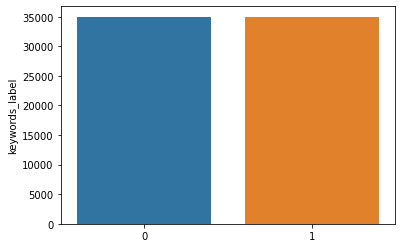

In [ ]:
# Check if Lyme and non-Lyme tweets have balanced representation
x = df['keywords_label'].value_counts()
print(x)
sns.barplot(x.index,x);

In [ ]:
# Source/reference- https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

#Convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = str(text)
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# Stopword Removal
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
    
#Lemmatization
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [ ]:
# Remove any rows with NaN (empty string) values due to stopword preprocessing
df['final_cleaned_text'] = df['fixed_text'].apply(lambda x: finalpreprocess(x))
df['final_cleaned_text'].replace('', np.nan, inplace=True)
df.dropna(subset=['final_cleaned_text'], inplace=True)
len(df)

69928

In [ ]:
# OPTIONAL: Create baseline dataframe with tweets randomly labelled with 0 (non-Lyme) and 1 (Lyme)
data = np.random.randint(0,2,size=len(df))
df['random_label'] = data

In [ ]:
# Save the cleaned tweets in CSV for future load
df.to_csv('All_Keywords_70k_No_GeoPy.csv', index=False, header=True)

In [ ]:
# Load the cleaned tweets CSV file
df = pd.read_csv('All_Keywords_70k_No_GeoPy.csv', dtype=None)
len(df), df.columns

(69928,
 Index(['id', 'text', 'keywords_label', 'fixed_text', 'final_cleaned_text',
        'random_label'],
       dtype='object'))

In [ ]:
#Split dataset into train and test for baseline (randomly labeled) model
X_train, X_test, y_train, y_test = train_test_split(df['final_cleaned_text'],df['random_label'], test_size=0.2, shuffle=True)

In [ ]:
#TF-IDF Embedding
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Word2Vec Embedding
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

df['clean_text_tok']=[nltk.word_tokenize(i) for i in df['final_cleaned_text']]
model = Word2Vec(df['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))     
modelw = MeanEmbeddingVectorizer(w2v)


# Tokenize sentences for Word2Vec
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

# Converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

NameError: ignored

In [ ]:
# Function for predicting y value for test dataset and evaluating classification metrics
def predict_score(model, X_test_vector, y_test):
    global y_predict
    y_predict = model.predict(X_test_vector)
    global y_prob
    y_prob = model.predict_proba(X_test_vector)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    return (print(classification_report(y_test,y_predict)),
            print('Confusion Matrix:',confusion_matrix(y_test, y_predict)),
            print('AUC:', roc_auc))

In [ ]:
#Fit the baseline model via Logistic Regression (TF-IDF) without cross-validation
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)
print(predict_score(lr_tfidf, X_test_vectors_tfidf, y_test))

#Fit the baseline model via Logistic Regression (Word2Vec) without cross-validation
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)
print(predict_score(lr_w2v, X_val_vectors_w2v, y_test))

              precision    recall  f1-score   support

           0       0.50      0.48      0.49      7025
           1       0.49      0.51      0.50      6961

    accuracy                           0.49     13986
   macro avg       0.49      0.49      0.49     13986
weighted avg       0.49      0.49      0.49     13986

Confusion Matrix: [[3339 3686]
 [3398 3563]]
AUC: 0.49765027420181884
(None, None, None)
              precision    recall  f1-score   support

           0       0.50      0.36      0.42      7025
           1       0.49      0.63      0.55      6961

    accuracy                           0.50     13986
   macro avg       0.50      0.50      0.49     13986
weighted avg       0.50      0.50      0.49     13986

Confusion Matrix: [[2540 4485]
 [2572 4389]]
AUC: 0.4952229017694415
(None, None, None)


In [ ]:
# Split dataset into train and test for NLP Classification Model
X_train, X_test, y_train, y_test = train_test_split(df['final_cleaned_text'], df['keywords_label'], test_size=0.2, shuffle=True)

In [ ]:
# TF-IDF Embedding
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Word2Vec Embedding
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

df['clean_text_tok']=[nltk.word_tokenize(i) for i in df['final_cleaned_text']]
model = Word2Vec(df['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))     
modelw = MeanEmbeddingVectorizer(w2v)


# Tokenize sentences for Word2Vec
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

# Converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

In [ ]:
# Fit the classification model via Logistic Regression (TF-IDF) without cross-validation
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)
print(predict_score(lr_tfidf, X_test_vectors_tfidf, y_test))

# Fit the classification model via Logistic Regression (TF-IDF) with cross-validation
lr_cv_tfidf=LogisticRegressionCV(solver = 'liblinear', cv=7, Cs=10, penalty = 'l2')
lr_cv_tfidf.fit(X_train_vectors_tfidf, y_train)
print(predict_score(lr_cv_tfidf, X_test_vectors_tfidf, y_test))

# Fit the classification model using Naive Bayes (TF-IDF)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)
print(predict_score(nb_tfidf, X_test_vectors_tfidf, y_test))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6865
           1       0.98      0.92      0.95      7121

    accuracy                           0.95     13986
   macro avg       0.95      0.95      0.95     13986
weighted avg       0.95      0.95      0.95     13986

Confusion Matrix: [[6712  153]
 [ 547 6574]]
AUC: 0.9808753854529748
(None, None, None)
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6865
           1       0.97      0.92      0.95      7121

    accuracy                           0.95     13986
   macro avg       0.95      0.95      0.95     13986
weighted avg       0.95      0.95      0.95     13986

Confusion Matrix: [[6663  202]
 [ 538 6583]]
AUC: 0.9801449668323015
(None, None, None)
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      6865
           1       0.83      0.94      0.88      7121

    ac

In [ ]:
# Fit the classification model via Logistic Regression (Word2Vec) without cross-validation
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)
print(predict_score(lr_w2v, X_val_vectors_w2v, y_test))

# Fit the classification model via Logistic Regression (Word2Vec) with cross-validation
lr_cv_w2v=LogisticRegressionCV(solver = 'liblinear', cv=7, Cs=10, penalty = 'l2')
lr_cv_w2v.fit(X_train_vectors_w2v, y_train)
print(predict_score(lr_cv_w2v, X_val_vectors_w2v, y_test))

# Fit the classification model using Naive Bayes (Word2Vec)
# nb_w2v = MultinomialNB()
# nb_w2v.fit(X_train_vectors_w2v, y_train)
# print(predict_score(nb_w2v, X_val_vectors_w2v, y_test))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90      6950
           1       0.95      0.84      0.89      7036

    accuracy                           0.90     13986
   macro avg       0.90      0.90      0.90     13986
weighted avg       0.90      0.90      0.90     13986

Confusion Matrix: [[6649  301]
 [1120 5916]]
AUC: 0.9476807047823934
(None, None, None)
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      6950
           1       0.95      0.85      0.90      7036

    accuracy                           0.90     13986
   macro avg       0.91      0.90      0.90     13986
weighted avg       0.91      0.90      0.90     13986

Confusion Matrix: [[6647  303]
 [1088 5948]]
AUC: 0.9491135210080941
(None, None, None)


In [ ]:
# Load the 7.5k Ground Truth Dataset
test_data_7point5k = pd.read_csv('NLP_test.csv')

1    3799
0    3701
Name: true_label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


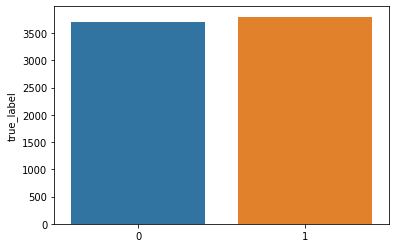

In [ ]:
# Check if Lyme and non-Lyme tweets have balanced representation
x = test_data_7point5k['true_label'].value_counts()
print(x)
sns.barplot(x.index,x);

In [ ]:
# Test TF-IDF Log Reg, Log Reg CV, and Naive Bayes on 7.5k Ground Truth Data
# Pre-process the test dataset
test_data_7point5k['clean_text'] = test_data_7point5k['fixed_text'].apply(lambda x: finalpreprocess(x))
X_test = test_data_7point5k['clean_text']

# Convert words to numerical data using TF-IDF
X_vector = tfidf_vectorizer.transform(X_test)

# Use models to predict class value for the test dataset 
predict_score(lr_tfidf, X_vector, test_data_7point5k['true_label'])
predict_score(lr_cv_tfidf, X_vector, test_data_7point5k['true_label'])
predict_score(nb_tfidf, X_vector, test_data_7point5k['true_label'])

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      3701
           1       0.94      0.81      0.87      3799

    accuracy                           0.88      7500
   macro avg       0.89      0.88      0.88      7500
weighted avg       0.89      0.88      0.88      7500

Confusion Matrix: [[3514  187]
 [ 711 3088]]
AUC: 0.9395640813055441
              precision    recall  f1-score   support

           0       0.83      0.94      0.89      3701
           1       0.94      0.82      0.87      3799

    accuracy                           0.88      7500
   macro avg       0.89      0.88      0.88      7500
weighted avg       0.89      0.88      0.88      7500

Confusion Matrix: [[3491  210]
 [ 692 3107]]
AUC: 0.9359857281232515
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      3701
           1       0.82      0.90      0.86      3799

    accuracy                           0.85 

(None, None, None)

In [ ]:
# Test Word2Vec Log Reg, Log Reg CV on 7.5k Ground Truth Data

# Convert words to numerical data using Word2Vec
X_test_tok= [nltk.word_tokenize(i) for i in X_test]
X_vector = modelw.transform(X_test_tok)

# Use models to predict class value for the test dataset 
predict_score(lr_w2v, X_vector, test_data_7point5k['true_label'])
predict_score(lr_cv_w2v, X_vector, test_data_7point5k['true_label'])
#predict_score(nb_w2v, X_vector, test_data_7point5k['true_label'])

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      3701
           1       0.94      0.76      0.84      3799

    accuracy                           0.85      7500
   macro avg       0.86      0.85      0.85      7500
weighted avg       0.87      0.85      0.85      7500

Confusion Matrix: [[3513  188]
 [ 928 2871]]
AUC: 0.9152235699051622
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      3701
           1       0.94      0.76      0.84      3799

    accuracy                           0.85      7500
   macro avg       0.86      0.85      0.85      7500
weighted avg       0.87      0.85      0.85      7500

Confusion Matrix: [[3508  193]
 [ 921 2878]]
AUC: 0.9163075594275688


(None, None, None)

Index(['id', 'text', 'label', 'fixed_text'], dtype='object')
1    2003
0    1997
Name: label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


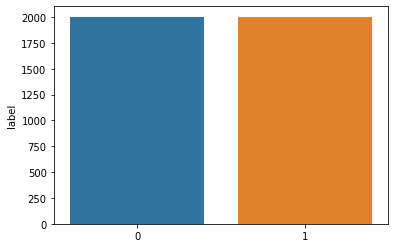

In [ ]:
# Load the 4k Ground Truth Dataset
test_data_4k = pd.read_csv('NLP_test_4k.csv')
print(test_data_4k.columns)

# Check if Lyme and non-Lyme tweets have balanced representation
x = test_data_4k['label'].value_counts()
print(x)
sns.barplot(x.index,x);

In [ ]:
# Test TF-IDF Log Reg, Log Reg CV, and Naive Bayes on 4k Ground Truth Data
# Pre-process the test dataset
test_data_4k['clean_text'] = test_data_4k['fixed_text'].apply(lambda x: finalpreprocess(x))
X_test = test_data_4k['clean_text']

# Convert words to numerical data using TF-IDF
X_vector = tfidf_vectorizer.transform(X_test)

# Use models to predict class value for the test dataset 
predict_score(lr_tfidf, X_vector, test_data_4k['label'])
predict_score(lr_cv_tfidf, X_vector, test_data_4k['label'])
predict_score(nb_tfidf, X_vector, test_data_4k['label'])

              precision    recall  f1-score   support

           0       0.83      0.95      0.88      1997
           1       0.94      0.81      0.87      2003

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

Confusion Matrix: [[1889  108]
 [ 386 1617]]
AUC: 0.9396087391196631
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1997
           1       0.93      0.81      0.87      2003

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

Confusion Matrix: [[1882  115]
 [ 378 1625]]
AUC: 0.9361877314223956
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1997
           1       0.81      0.90      0.86      2003

    accuracy                           0.85 

(None, None, None)

In [ ]:
# Test Word2Vec Log Reg, Log Reg CV on 4k Ground Truth Data

# Convert words to numerical data using Word2Vec
X_test_tok= [nltk.word_tokenize(i) for i in X_test]
X_vector = modelw.transform(X_test_tok)

# Use models to predict class value for the test dataset 
predict_score(lr_w2v, X_vector, test_data_4k['label'])
predict_score(lr_cv_w2v, X_vector, test_data_4k['label'])
#predict_score(nb_w2v, X_vector, test_data_4k['true_label'])

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1997
           1       0.94      0.75      0.83      2003

    accuracy                           0.85      4000
   macro avg       0.86      0.85      0.85      4000
weighted avg       0.86      0.85      0.85      4000

Confusion Matrix: [[1893  104]
 [ 497 1506]]
AUC: 0.9125884283239637
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1997
           1       0.94      0.75      0.84      2003

    accuracy                           0.85      4000
   macro avg       0.86      0.85      0.85      4000
weighted avg       0.87      0.85      0.85      4000

Confusion Matrix: [[1895  102]
 [ 494 1509]]
AUC: 0.9136536807207816


(None, None, None)

In [ ]:
# Classify the 420k Geopy Tweets

# Load the 420k Dataset for Classification
classify_420k_tweets = pd.read_csv('tweets_420k.csv')
#classify_420k_tweets['BERT_pred_label'] = classify_420k_tweets['pred_label']
len(classify_420k_tweets), classify_420k_tweets.columns

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(419461, Index(['id', 'text', 'author_id', 'public_metrics', 'created_at',
        'in_reply_to_user_id', 'conversation_id', 'reply_settings', 'source',
        'referenced_tweets', 'context_annotations', 'entities', 'user',
        'user_name', 'user_location', 'city', 'state', 'county', 'country',
        'cty_st', 'year', 'keywords_label', 'month'],
       dtype='object'))

1    334629
0     84832
Name: keywords_label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


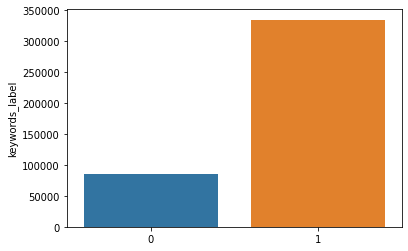

In [ ]:
# Check if Lyme and non-Lyme tweets have balanced representation
x = classify_420k_tweets['keywords_label'].value_counts()
print(x)
sns.barplot(x.index,x);

In [ ]:
#Pre-processing the Geopy dataset
classify_420k_tweets['final_cleaned_text'] = classify_420k_tweets['text'].apply(lambda x: finalpreprocess(x))
X_test = classify_420k_tweets['final_cleaned_text']

# Convert words to numerical data using TF-IDF
X_vector=tfidf_vectorizer.transform(X_test)

# Use model to predict class value for the dataset 
predict_score(lr_tfidf, X_vector, classify_420k_tweets['keywords_label'])

classify_420k_tweets['TF_IDF_pred_proba']= y_prob
classify_420k_tweets['TF_IDF_pred_label']= y_predict
TFIDF_LogReg_classified_df = classify_420k_tweets[['final_cleaned_text', 'county', 'year', 'TF_IDF_pred_label']].reset_index(drop=True)
print(TFIDF_LogReg_classified_df.head())

              precision    recall  f1-score   support

           0       0.74      0.98      0.85     84832
           1       0.99      0.91      0.95    334629

    accuracy                           0.93    419461
   macro avg       0.87      0.95      0.90    419461
weighted avg       0.94      0.93      0.93    419461

Confusion Matrix: [[ 83226   1606]
 [ 28874 305755]]
AUC: 0.9756394266055552
                                  final_cleaned_text           county  year  \
0  lyme regis eco friendly woodroffe school win g...   Jackson County  2010   
1  dog contract lyme disease several question ask...   Forsyth County  2010   
2  lymejournal rt lymehurts adhd depression anxie...   Spokane County  2010   
3  luv lyme lol wow gon na break verse even jesus...  Davidson County  2010   
4  luv lyme guess answer yesterday question karma...  Davidson County  2010   

   TF_IDF_pred_label  
0                  0  
1                  1  
2                  1  
3                  0  
4     

In [ ]:
# Create CSV with Final Predictions
TFIDF_LogReg_classified_df.to_csv('All_Keywords_TFIDFLogReg_Preds_GeoPy_420k_Tweets.csv', index=False, header=True)